In [42]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, Callable
from numba import njit, prange
from copy import copy

up = "\u2191"  # ↑
down = "\u2193"  # ↑

boundary_conditions = {
    "periodic",
    "aperiodic",
    "buffered",
    "random",
}

# TODO: add glass
magnetic_character = {
    "ferromagnetic": 1,
    "antiferromagnetic": 1,
    "paramagnetic": 0,
}


def hamiltonian(lattice: "SpinLattice") -> float | int:

    """


    """
    interaction_energy = 0.0
    h_energy = np.sum(-lattice.spins * lattice.h)
    for i in range(1, lattice.N + 1):
        for j in range(1, lattice.N + 1):
            spin = lattice.spins[i, j]
            neighbors = np.array(
                [
                    lattice.spins[i - 1, j],
                    lattice.spins[i + 1, j],
                    lattice.spins[i, j - 1],
                    lattice.spins[i, j + 1],
                ]
            )

        interaction_energy += np.sum(-lattice.J * neighbors * spin)

    H = -lattice.J * interaction_energy - h_energy
    return H

# @njit(fastmath=True, parallel=True)
# def infinite_range_hamiltonian(lattice, J, h) -> float | int:
    """
    Computes the Hamiltonian for an infinite-range (mean-field) spin glass model.

    This function calculates the energy of a given spin configuration `lattice`
    under the influence of a random interaction matrix `J` and an external 
    magnetic field `h`. The model assumes infinite-range interactions, meaning 
    every spin interacts with all other spins in the system.

    Parameters:
    -----------
    lattice : np.ndarray
        A 2D array representing the spin configuration, where each element is
        either +1 or -1.
    J : np.ndarray
        A 2D interaction matrix containing coupling strengths between spins.
        Must have the same shape as `lattice`.
    h : float | int
        The external magnetic field strength.

    Returns:
    --------
    H : float | int
        The total energy of the system.

    Notes:
    ------
    - The interaction term sums over all pairs (i, j) and (k, l), ensuring that
      each spin interacts with every other spin.
    - The energy is symmetrized by dividing the interaction term by 2 to avoid 
      double counting.
    - The external field term contributes `h * sum(lattice)`, affecting all spins.

    Example:
    --------
    >>> import numpy as np
    >>> lattice = np.array([[1, -1], [-1, 1]])  # 2x2 spin configuration
    >>> J = np.random.normal(0, 1, (2, 2))  # Random interaction matrix
    >>> h = 0.5  # External magnetic field
    >>> infinite_range_hamiltonian(lattice, J, h)
    -1.23  # Example output (varies due to randomness in J)
    """
    N, _ = lattice.shape
    interaction_energy = 0.0
    for i in range(N):
        for j in range(N):
            si = lattice[i,j]
            ji = J[i,j]
            for k in range(N):
                for l in range(N):
                    sj = lattice[k,l]
                    if (i, j) != (k, l):
                        interaction_energy += ji*si*sj

    interaction_energy *= 0.5
    field_energy = h*np.sum(lattice)
    H = -1.0*(interaction_energy+field_energy)
    
    return H

@njit(fastmath=True, parallel=True)
def infinite_range_hamiltonian(lattice: np.ndarray, J: np.ndarray, h: float) -> float:
    """
    Computes the Hamiltonian for an infinite-range (mean-field) spin glass model
    using NumPy optimizations and Numba acceleration.

    Parameters:
    -----------
    lattice : np.ndarray
        A 2D array of spins (+1 or -1).
    J : np.ndarray
        A 2D interaction matrix (same shape as `lattice`).
    h : float
        External magnetic field strength.

    Returns:
    --------
    H : float
        The total energy of the system.
    """

    N, M = lattice.shape  # Get lattice dimensions
    interaction_energy = 0.0

    # Compute interaction term efficiently
    for i in prange(N):
        for j in range(M):
            si = lattice[i, j]
            ji = J[i, j]
            for k in range(N):
                for l in range(M):
                    if (i, j) != (k, l):
                        sj = lattice[k, l]
                        interaction_energy += ji * si * sj  # Summing interactions

    # Normalize interaction term by dividing by 2 to remove double counting
    interaction_energy *= 0.5
    # Compute external field contribution
    field_energy = h * np.sum(lattice)
    # Compute total Hamiltonian
    H = -1.0 * (interaction_energy + field_energy)

    return H

def monte_carlo(lattice:np.ndarray[:,:]= None,
                J: np.ndarray[:,:] = None,
                h: (int | float) = None,  
                β: (int | float) = 0.0, 
                dimension : int = 2, 
                iterations: (int) = 10000 , 
                hamiltonian: callable=infinite_range_hamiltonian) -> list:
    
    """
    Performs a Monte Carlo simulation using the Metropolis-Hastings algorithm 
    for a given spin system.

    This function simulates the evolution of a spin system over `iterations` 
    using Monte Carlo updates. At each step, a random spin is selected, flipped, 
    and the change in energy (ΔE) is calculated. The move is accepted based on 
    the Metropolis criterion.

    Parameters:
    -----------
    lattice : SpinLattice
        An instance of the SpinLattice class representing the spin system. 
        It must have attributes `spins`, `N`, `dimension`, `J`, `h`, and `β` 
        (inverse temperature).
    iterations : int
        The number of Monte Carlo steps to perform.
    hamiltonian : callable, optional (default: infinite_range_hamiltonian)
        A function that computes the Hamiltonian of the system.

    Returns:
    --------
    configurations : np.ndarray
        A 3D NumPy array of shape `(iterations, lattice.spins.shape)`, storing 
        the spin configurations at each Monte Carlo step.

    Notes:
    ------
    - Uses the Metropolis criterion: Accept all moves that lower energy (ΔE < 0), 
      otherwise accept with probability `exp(-βΔE)`.
    - The function modifies `lattice.spins` in place.
    - The `index` selection may need adjustment if `lattice.dimension > 1`.
    - The energy is computed before and after flipping a randomly selected spin.

    Example:
    --------
    >>> import numpy as np
    >>> lattice = SpinLattice(N=10, temperature=1.0)
    >>> configs = monte_carlo(lattice, iterations=1000)
    >>> configs.shape
    (1000, 10, 10)  # Example output for a 10x10 lattice

    """

    configurations = np.zeros((iterations,*lattice.shape), dtype=np.float64)
    N = lattice.shape[0]
    for i in range(0, iterations):
        index = np.random.choice(
            np.arange(N ), dimension, replace=False
        )
        E0 = infinite_range_hamiltonian(lattice,J,h)
        lattice[*index] = -1.0 * lattice[*index]
        E = infinite_range_hamiltonian(lattice,J,h)
        ΔE = E - E0
        if ΔE < 0:
            pass
        else:
            p = np.exp(-β * ΔE)
            if np.random.rand() > p:
                lattice[*index] = -1.0 * lattice[*index]  # Revert move
    
        configurations[i] = lattice
    return configurations


def replica_exchange_monte_carlo(lattice:np.ndarray[:,:]= None,
                J: np.ndarray[:,:] = None,
                h: (int | float) = None,  
                βs: (int | float) = 0.0, 
                dimension : int = 2, 
                iterations: (int) = 10000 , 
                hamiltonian: callable=infinite_range_hamiltonian,
                n_replicas: int = 10): 
    


    configurations = np.zeros((iterations,*lattice.shape), dtype=np.float64)
    N = lattice.shape[0]
    for i in range(0, iterations):
        index = np.random.choice(
            np.arange(N ), dimension, replace=False
        )
        E0 = infinite_range_hamiltonian(lattice,J,h)
        lattice[*index] = -1.0 * lattice[*index]
        E = infinite_range_hamiltonian(lattice,J,h)
        ΔE = E - E0
        if ΔE < 0:
            pass
        else:
            p = np.exp(-β * ΔE)
            if np.random.rand() > p:
                lattice[*index] = -1.0 * lattice[*index]  # Revert move
    
        configurations[i] = lattice
    return configurations



# @njit
# def jittted_monte_carlo():

# TODO: add dimension
class SpinLattice:
    def __init__(
        self,
        N: (int | float),
        dimension: (int) = 2,
        temperature: (int | float) = 1,
        boundary_condition: str = "buffered",
        spin_number: (int | float) = 1 / 2,
        scale_number: (int | float) = 2,
        buffer_pad: (int | float) = 0,
        interaction_strength: (int | float) = 1.0,
        magnetic_strength: (int | float) = 1.0,
        seed=1917,
    ):
        
        self.inverse_temperature = 1 / temperature
        self.β = 1 / temperature
        self.dimension = dimension
        self.d = dimension
        self.N = N
        final_value = (spin_number + 0.5
                       if spin_number % 1 != 0 else spin_number + 1)
        spin_values = np.arange(-spin_number, final_value, dtype=np.float64) * scale_number
        self.spins = np.random.choice(spin_values, size=(self.N, self.N))
        self.h = magnetic_strength
        self.bc = boundary_condition
        self.J = interaction_strength
        self.interaction_strength = interaction_strength

        if self.bc == "buffered":
            # https://numpy.org/doc/stable/reference/generated/numpy.pad.html
            self.spins = np.pad(self.spins, pad_width=1)
        

    def __str__(self):
        spin_string = np.where(
            self.spins == 1, up, np.where(self.spins == -1, down, self.spins)
        )
        return str(spin_string[1: self.N + 1, 1: self.N + 1])
    
# TODO: add dimension
class SpinGlass(SpinLattice):
    def __init__(
        self,
        N: Union[int, float],
        dimension: int = 2,
        temperature: Union[int, float] = 1,
        boundary_condition: str = None,
        spin_number: Union[int, float] = 1 / 2,
        scale_number: Union[int, float] = 2,
        magnetic_strength: Union[int, float] = 1.0,
        seed: int = 1917,
        bond_distribution: Callable = np.random.normal,
        mean: Union[int, float] = 0.0, 
        variance: Union[int, float] = 0.0
    ):    
        super().__init__(N, dimension, temperature, boundary_condition, spin_number,
                         scale_number, magnetic_strength, seed)

        self.J = bond_distribution(loc=mean, scale=1/int(N)**(-1/2), size=(int(N), int(N)))

        if boundary_condition == "buffered":
            # Ensure self.spins is initialized in the parent class before using it
            if hasattr(self, 'spins'):
                self.spins = np.pad(self.spins, pad_width=1)
            else:
                raise AttributeError("Parent class must initialize self.spins before padding.")

    def __str__(self):
        up = "↑"
        down = "↓"
        spin_string = np.where(
            self.spins == 1, up, np.where(self.spins == -1, down, self.spins)
        )
        return str(spin_string[1: self.N + 1, 1: self.N + 1])


def replica_exchange_monte_carlo(replicas: list[SpinLattice] ,
                                 βs: list[float],
                                 n_exchanges: (int | float),
                                 iteration_per_exchange: (int | float)=100, 
                                 burnin: int = 100,
                                 inplace: bool=False):
    """
    Perform Replica Exchange Monte Carlo (REMC) on a set of replicas, simulating spin configurations
    at different inverse temperatures (βs) and swapping configurations between adjacent replicas.

    Parameters:
    -----------
    S : list[np.ndarray[:]]
        A list of arrays representing the spin configurations for each replica.
    
    replicas : list[NeuralNetworkwMemory]
        A list of objects, where each object represents a replica (e.g., a neural network with weights).

    βs : list[float]
        A list of inverse temperatures (β values) corresponding to each replica.
    
    n : int | float, optional, default=10
        The number of exchange cycles to perform. Each cycle includes spin updates 
        and attempted exchanges between adjacent replicas.

    iteration_per_exchange : int | float, optional, default=100
        The number of Monte Carlo iterations to run on each replica between exchange attempts.

    inplace : bool, optional, default=False
        If True, modifies the input `S` and `replicas` directly. If False, deep copies are used,
        and the original inputs remain unchanged.

    Returns:
    --------
    replicas_ : list[NeuralNetworkwMemory]
        The list of updated replicas after the REMC process.

    S_ : list[np.ndarray[:]]
        The list of updated spin configurations for each replica.

    Notes:
    ------
    - The algorithm alternates between simulating the replicas independently (using `monte_carlo_on_spins`) 
      and attempting exchanges between adjacent replicas.
    - Exchanges are performed based on the Metropolis-like probability that ensures detailed balance:
        P_exchange = min(1, exp((β_i - β_{i+1}) * (E_{i+1} - E_i)))
      where E_i is the Hamiltonian energy of replica `i`.
    - If `inplace=True`, the input `S` and `replicas` are directly modified.

    Example Usage:
    --------------
    >>> replicas = [NeuralNetworkwMemory(weights=np.random.rand(5, 5)) for _ in range(4)]
    >>> S = [np.random.choice([-1, 1], size=(5,)) for _ in range(4)]
    >>> βs = [1.0, 0.8, 0.6, 0.4]
    >>> replicas_, S_ = replica_exchange_monte_carlo(S, replicas, βs, n=20, iteration_per_exchange=200)
    """

    if inplace is True:
        replicas_ = replicas
    else:
        replicas_ = (copy(replicas))


    n_replicas = len(replicas)
    N = replicas_[0].N
    total_configs = np.zeros((n_replicas, n_exchanges, iteration_per_exchange, N, N))  # Adjust sizes as needed
    for n in range(0,n_exchanges):
        # **Step 1: Perform parallel Monte Carlo updates on each replica**
        for i in range(len(replicas_,)): 
            r , β = replicas_[i], βs[i]
            lattice, J , h = r.spins, r.spins, r.h
            s = monte_carlo(lattice=lattice,
                            J=J,
                            h=h,
                            β=β,
                            iterations=iteration_per_exchange)
            
            total_configs[i,n,:] = s 
        # exchange the replicas 
        for i in range(0,n_replicas-1):
            r1 , r = replicas_[i+1], replicas_[i]
            E0, E1 = (infinite_range_hamiltonian(r.spins, r.J ,r.h), 
                      infinite_range_hamiltonian(r1.spins, r1.J ,r1.h))
            P_exchange = np.min([1,np.exp((βs[i]-βs[i+1])*(E1-E0))])
            r = np.random.rand()
            if P_exchange > r:
                replicas_[i], replicas_[i+1] = replicas_[i+1], replicas_[i]
                total_configs[i,n,:,:,:], total_configs[i+1,n,:,:,:] = total_configs[i+1,n,:,:,:], total_configs[i,n,:,:,:]

            else : 
                pass 

    return total_configs


N = 32
config_n = int(1e2)
n_exchanges = 100
lattice = SpinGlass(N=N, temperature=.0000001, magnetic_strength=0.0)
n_replicas = 10
replicas = [copy(lattice) for _ in range(n_replicas)] 
βs = np.arange(0.1,10)
results = replica_exchange_monte_carlo(replicas, βs, n_exchanges, config_n,.1*config_n)


In [54]:
n_replicas = 10
flattened_arrays = results.reshape(n_replicas, -1, N, N)
flattened_arrays[0].shape

(10000, 32, 32)

In [55]:
replica_energies = [[infinite_range_hamiltonian(l,lattice.J,lattice.h) for l in L]  for L in flattened_arrays] 

In [ ]:
lattice = SpinGlass(N=N, temperature=.0000001, magnetic_strength=0.0)
spins = lattice.spins
configs = monte_carlo(spins,J=lattice.J, h= lattice.h, β=0.0, iterations= config_n)
J, h = lattice.J,lattice.h
energies = [infinite_range_hamiltonian(c, J, h)/N for c in configs]
print("U(β=0):", np.sum(energies)/config_n)

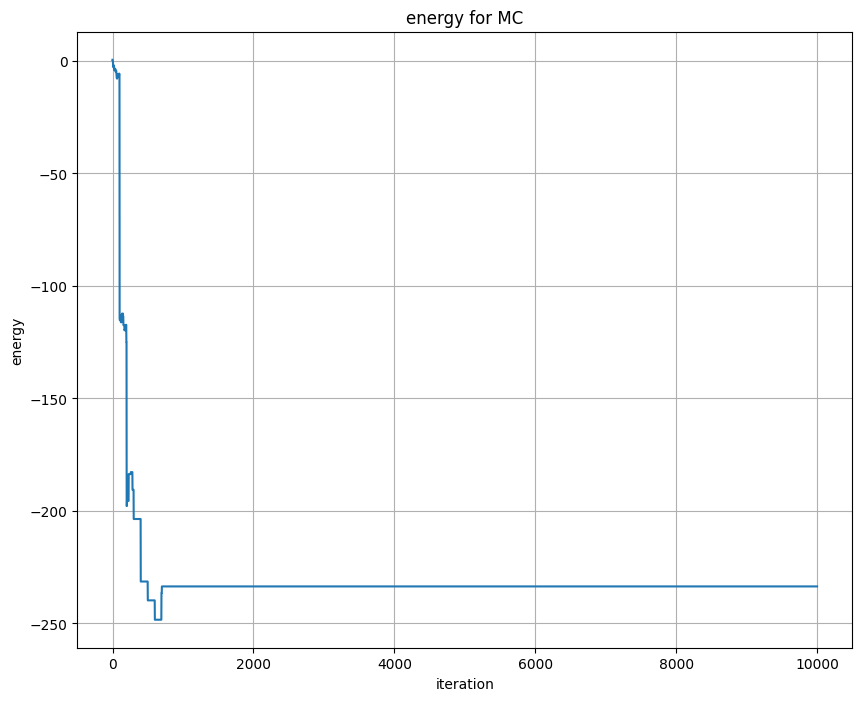

In [56]:
replica_energies = [[e/(N**2) for e in L]  for L in replica_energies] 

plt.figure(figsize=(10,8))
plt.title("energy for MC")
plt.plot(np.arange(0,len(energies)), energies)
plt.xlabel("iteration")
plt.ylabel("energy")
plt.grid()

plt.figure(figsize=(10,8))
plt.title("energy for MC")
plt.plot(np.arange(0,len(energies)), energies)
plt.xlabel("iteration")
plt.ylabel("energy")
plt.grid()

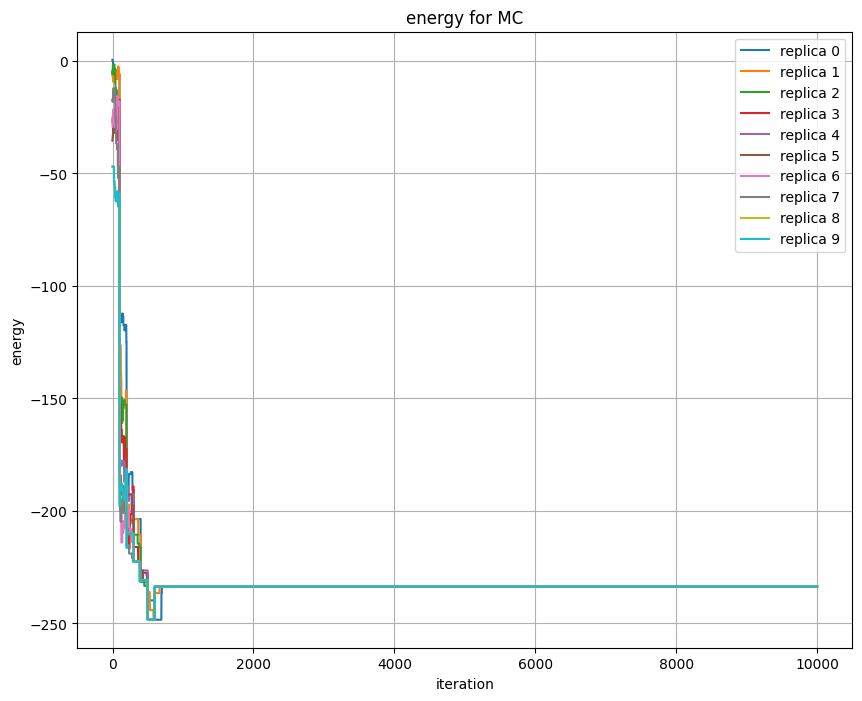

In [ ]:
plt.figure(figsize=(10,8))
for l in range(len(replica_energies)):
    print(f"U(β={βs}):", np.sum(energies)/config_n)
    plt.title("energy for MC")
    plt.plot(np.arange(0,len(replica_energies[l])), replica_energies[l], label=f"replica {l}")
    plt.xlabel("iteration")
    plt.ylabel("energy")

plt.grid()
plt.legend()

In [4]:
1e6

1000000.0

In [24]:
@njit
def create_2D_array(N: int):
    return np.zeros((N, N), dtype=np.float64)  # ✅ Correct

In [ ]:
len(replica_energies

[[0.5368373226135073,
  0.5368373226135073,
  0.3060721244806328,
  0.3060721244806328,
  -0.4627400167114728,
  -0.4627400167114728,
  -0.4627400167114728,
  -1.3334619486846564,
  -2.2178418582767105,
  -2.2178418582767105,
  -2.2178418582767105,
  -2.7394429227147565,
  -2.5051453140553916,
  -2.4989542780561935,
  -2.4989542780561935,
  -2.4989542780561935,
  -1.925381244388341,
  -2.460685689688755,
  -2.460685689688755,
  -2.460685689688755,
  -2.9136003685582903,
  -3.729599983261548,
  -3.966292301832167,
  -3.966292301832167,
  -3.966292301832167,
  -3.6092647834889036,
  -3.1889952962864307,
  -3.1889952962864307,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.994782534344732,
  -3.487368480332109,
  -3.595115562130035,
  -3.595115562130035,
  -3.631332354430642,
  -4.474340458673294,
  -4.704333255556149,
  -4.50133944169683,
  -4.501339441696

In [ ]:

N = 1000
lattice = SpinGlass(N=N, temperature=.0000001, magnetic_strength=0.0)
a = infinite_range_hamiltonian(lattice.spins,lattice.J,lattice.h)

1e-07


In [49]:
b = infinite_range_hamiltonian2(lattice.spins,lattice.J,lattice.h)

In [39]:
np.allclose(a,b)

True

In [34]:
a

1059.7271811600383

In [47]:
lattice.spins.shape

(100, 100)

In [59]:
lattice.spins

array([[-1., -1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ..., -1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ..., -1., -1.,  1.]])

In [54]:
βs

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1])